In [50]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import sys, os
import pandas as pd
from datetime import date

pd.get_option("display.max_rows",100)
'''/home/alonshp/.conda/envs/tf-env/bin/python'''

sys.path.append(os.path.abspath('../'))
print(sys.path)

['/sise/home/alonshp/AnomalyDetectionScreening/1.evaluate_screen', '/sise/home/alonshp/AnomalyDetectionScreening/1.evaluate_screen', '/home/alonshp/AnomalyDetectionScreening/ads', '/home/alonshp/.conda/envs/pytorch_ads/lib/python310.zip', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/lib-dynload', '', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages', '/sise/home/alonshp/AnomalyDetectionScreening', '/sise/home/alonshp/AnomalyDetectionScreening', '/tmp/tmpjurfk4sw', '/sise/home/alonshp/AnomalyDetectionScreening']


In [52]:
from ads.utils.percantage_replicates_utils import *
from ads.utils.plotting import *
# from ads.utils.constants import *
# from constants import *
from metrics import *

# Load data

In [53]:
ds_info_dict={'CDRP':['CDRP-BBBC047-Bray',['Metadata_Sample_Dose','pert_sample_dose']],
              'CDRP-bio':['CDRPBIO-BBBC036-Bray',['Metadata_Sample_Dose','pert_sample_dose']],
              'TAORF':['TA-ORF-BBBC037-Rohban',['Metadata_broad_sample','pert_id',]],
              'LUAD':['LUAD-BBBC041-Caicedo',['x_mutation_status','allele']],
              'LINCS':['LINCS-Pilot1',['Metadata_pert_id_dose','pert_id_dose']]}

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
# datasets=['TAORF','LUAD','LINCS', 'CDRP-bio']
datasets=['CDRP-bio']
# datasets=['LINCS']
dataset= datasets[0]
# DT_kfold={'LUAD':10, 'TAORF':5, 'LINCS':25, 'CDRP-bio':6,'CDRP':40}
exp_name = 'report_911_t'
by_dose = False
normalize_by_all = True
# from IPython.display import clear_output
################################################
# CP Profile Type options: 'augmented', 'augmented_after_fs' , 'normalized', 'normalized_variable_selected'
# profileType='augmented'
profileType ='normalized_variable_selected'

z_trim = 10
t_thresholds = [2]

In [54]:
from utils.general import add_exp_suffix

exp_suffix = add_exp_suffix(profileType,by_dose,normalize_by_all)

base_dir= '/sise/assafzar-group/assafzar/genesAndMorph'

data_dir=base_dir+'/preprocessed_data/'+ds_info_dict[datasets[0]][0]+'/'
output_dir = f'{base_dir}/anomaly_output/{datasets[0]}/{profileType}'  
output_dir = f'{base_dir}/anomaly_output/{datasets[0]}/CellPainting/{exp_name}'  
save_base_dir = f'{base_dir}/results/{datasets[0]}'
res_dir = f'{save_base_dir}/CellPainting/{exp_name}/'
exp_save_dir = f'{res_dir}/figs/PR'
# exp_name= 'autoencoder'
methods = {
    # '4to1':{'path':f'/storage/users/g-and-n/tabular_models_results/41/ALL/zscores'},
    # '2to1':{'path':f'/storage/users/g-and-n/tabular_models_results/21/ALL/zscores'},
    # 'anomaly':{'name':'anomaly','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae.csv')},
    'anomaly_err':{'name':'anomaly_err','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae_diff.csv')},
    # 'anomaly_emb':{'name':'anomaly_emb','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae_embeddings.csv')},
    'raw':{'name':'raw','path': os.path.join(output_dir,f'replicate_level_cp_{profileType}_baseline.csv')},
    # 'raw_unchanged':{'name':'raw_unchanged','path': os.path.join(data_dir,'CellPainting',f'replicate_level_cp_{profileType}.csv.gz')}
    # '5to5':{'path':f'/storage/users/g-and-n/tabular_models_results/55/ALL/zscores'},
}


p_vals_path = f'{res_dir}/df_null_p_vals{exp_suffix}.csv'
pr_path = f'{res_dir}/pr{exp_suffix}.csv'

os.makedirs(save_base_dir,exist_ok=True)
os.makedirs(exp_save_dir,exist_ok=True)

In [55]:
new_ss = False
ss_calc = 'median'

if by_dose:
    ind_col = 'dose_col'
else:
    ind_col = 'cpd_col'

In [56]:
# from ads.utils.data_utils import set_index_fields
# from dataset_paper_repo.utils.normalize_funcs import standardize_per_catX
from utils.global_variables import DS_INFO_DICT
from utils.eval_utils import load_zscores

methods = load_zscores(methods,base_dir,dataset,profileType,by_dose=by_dose,normalize_by_all =normalize_by_all,z_trim=z_trim)
# (methods,base_dir,dataset, profile_type,normalize_by_all=False,by_dose=False,z_trim=10)
####################### loading zscores #########################

for m in methods.keys():
       
    methods[m]['ind_col'] = DS_INFO_DICT[dataset][methods[m]['modality']][ind_col]

#     print(f'loading zscores for method: {m}')
    # if m == 'l1k':
        # methods[m]['modality'] ='L1000'
    #     scaled_zscores, features = load_data(configs,modality=methods[m]['modality'], plate_normalize_by_all =True)
    #     methods[m]['features']=list(features)

    #     scaled_zscores = scaled_zscores.query(f"{DS_INFO_DICT[dataset]['L1000']['role_col']} != '{DS_INFO_DICT[dataset]['L1000']['mock_val']}' ")
        
    #     # methods[m]['zscores'] = zscores.loc[:,methods[m]['features']]
    # else:
    #     methods[m]['modality']='CellPainting'
    #     zscores = pd.read_csv(methods[m]['path'], compression = 'gzip')     
    #     if m == 'anomaly_emb':
    #         meta_features = [c for c in zscores.columns if 'Metadata_' in c]
    #         features = [c for c in zscores.columns if 'Metadata_' not in c]
    #     else:
    #         features = zscores.columns[zscores.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
    #     methods[m]['features']=list(features)

    #     scaled_zscores = standardize_per_catX(zscores,DS_INFO_DICT[dataset]['CellPainting']['plate_col'],methods[m]['features'])
    # scaled_zscores = scaled_zscores.query(f"{DS_INFO_DICT[dataset][methods[m]['modality']]['role_col']} != '{DS_INFO_DICT[dataset][methods[m]['modality']]['mock_val']}' ")
    # # zscores = zscores.query('Metadata_ASSAY_WELL_ROLE == "treated"')
    # scaled_zscores = set_index_fields(scaled_zscores,dataset,by_dose=by_dose, modality=methods[m]['modality'])
    # if z_trim is not None:
    #     scaled_zscores[features] = scaled_zscores[features].clip(-z_trim, z_trim)
    # methods[m]['zscores'] = scaled_zscores.loc[:,methods[m]['features']]
 


loading zscores for method: anomaly_err


/home/alonshp/AnomalyDetectionScreening/ads/utils/eval_utils.py:25: DtypeWarning: Columns (10,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  zscores = pd.read_csv(methods[m]['path'], compression = 'gzip')


loading zscores for method: raw


In [57]:
methods['anomaly_err']['zscores'].head()

Cells_AreaShape_Center_X  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                             
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                            0.553478   
                                        BRD-K18316707-001-01-9 5.0000                    a02                           -0.083870   
                                        BRD-K18438502-001-02-6 5.0000                    a03                            0.909928   
                                        BRD-K18550767-001-02-8 5.0000                    a04                            2.031412   
                                        BRD-K18574842-323-03-3 2.1955                    a05                            0.363687   

                                                                                                        Cells_AreaShape_Compactness  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                                
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                               0.808080   
                                        BRD-K18316707-001-01-9 5.0000                    a02                               1.014796   
                                        BRD-K18438502-001-02-6 5.0000                    a03                               0.894483   
                                        BRD-K18550767-001-02-8 5.0000                    a04                               0.068278   
                                        BRD-K18574842-323-03-3 2.1955                    a05                              -0.015883   

                                                                                                        Cells_AreaShape_Extent  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                           
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                         -1.129265   
                                        BRD-K18316707-001-01-9 5.0000                    a02                         -1.972033   
                                        BRD-K18438502-001-02-6 5.0000                    a03                         -0.941181   
                                        BRD-K18550767-001-02-8 5.0000                    a04                          0.547555   
                                        BRD-K18574842-323-03-3 2.1955                    a05                         -0.175987   

                                                                                                        Cells_AreaShape_FormFactor  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                               
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                              0.594785   
                                        BRD-K18316707-001-01-9 5.0000                    a02                              0.236097   
                                        BRD-K18438502-001-02-6 5.0000                    a03                              0.185244   
                                        BRD-K18550767-001-02-8 5.0000                    a04                              0.359565   
                                        BRD-K18574842-323-03-3 2.1955                    a05                              0.112968   

                                                                                                        Cells_AreaShape_Orientation  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                                
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                     

In [58]:
methods['raw']['zscores'].head()

Cells_AreaShape_Center_X  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                             
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                           -0.793987   
                                        BRD-K18316707-001-01-9 5.0000                    a02                            0.313736   
                                        BRD-K18438502-001-02-6 5.0000                    a03                           -1.388875   
                                        BRD-K18550767-001-02-8 5.0000                    a04                           -3.235059   
                                        BRD-K18574842-323-03-3 2.1955                    a05                           -0.568336   

                                                                                                        Cells_AreaShape_Compactness  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                                
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                               0.712654   
                                        BRD-K18316707-001-01-9 5.0000                    a02                              -0.089728   
                                        BRD-K18438502-001-02-6 5.0000                    a03                              -0.671386   
                                        BRD-K18550767-001-02-8 5.0000                    a04                               1.313307   
                                        BRD-K18574842-323-03-3 2.1955                    a05                               0.680858   

                                                                                                        Cells_AreaShape_Extent  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                           
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                         -0.390854   
                                        BRD-K18316707-001-01-9 5.0000                    a02                          0.196528   
                                        BRD-K18438502-001-02-6 5.0000                    a03                          0.172327   
                                        BRD-K18550767-001-02-8 5.0000                    a04                         -0.819663   
                                        BRD-K18574842-323-03-3 2.1955                    a05                         -0.055029   

                                                                                                        Cells_AreaShape_FormFactor  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                               
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                             -0.589398   
                                        BRD-K18316707-001-01-9 5.0000                    a02                             -0.198156   
                                        BRD-K18438502-001-02-6 5.0000                    a03                              0.183552   
                                        BRD-K18550767-001-02-8 5.0000                    a04                             -0.239233   
                                        BRD-K18574842-323-03-3 2.1955                    a05                              0.031764   

                                                                                                        Cells_AreaShape_Orientation  \
Metadata_Plate Metadata_ASSAY_WELL_ROLE Metadata_broad_sample  Metadata_mmoles_per_liter Metadata_Well                                
24277          treated                  BRD-K18250272-003-03-7 3.0225                    a01                     

In [59]:
for m in methods.keys():
    print(methods[m]['zscores'].shape)

(17594, 591)
(17594, 591)


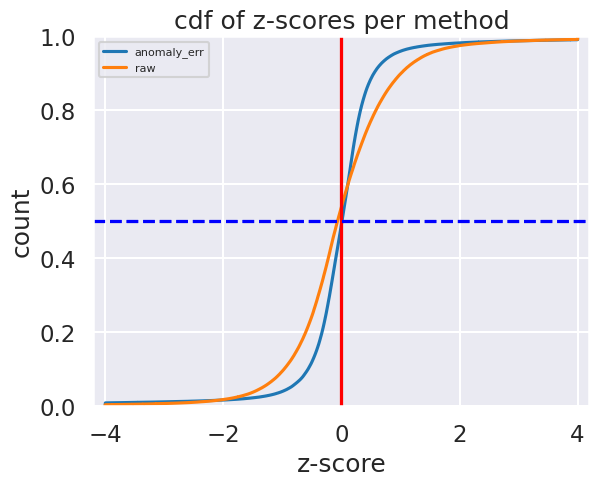

In [60]:
for m in methods.keys():
    zscores_clipped = methods[m]['zscores'].clip(-4,4)

    a = zscores_clipped[0:500].to_numpy().flatten()

    # sns.histplot(a, bins=100, kde=True, color='b')
    sns.ecdfplot(a,label=m)

    plt.axvline(x=0,color='r')
    plt.axhline(y=0.5,color='b',linestyle='--')
    plt.xlabel('z-score')
    plt.ylabel('count')
    plt.legend(fontsize=8)
    plt.xlim(-4.2,4.2)
    # plt.ylim(0,2000)
    plt.title('cdf of z-scores per method')
    # plt.show()
# p

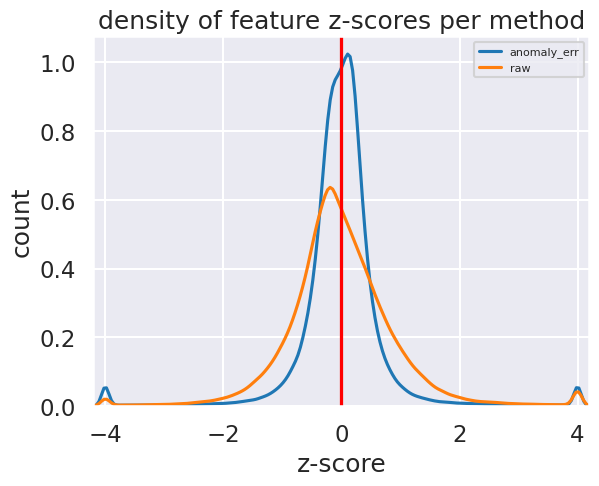

In [61]:
for m in methods.keys():
    zscores_clipped = methods[m]['zscores'].clip(-4,4)

    a = zscores_clipped[0:500].to_numpy().flatten()

    # sns.histplot(a, bins=100, kde=True, color='b')
    sns.kdeplot(a,label=m)

    plt.axvline(x=0,color='r')
    plt.xlabel('z-score')
    plt.ylabel('count')
    plt.legend(fontsize=8)
    plt.xlim(-4.2,4.2)
    # plt.ylim(0,2000)
    plt.title('density of feature z-scores per method')
    # plt.show()
# zscores_clipped.describe()
# p

# Plot sensitivity and complementry

In [62]:
def extract_ss_score(df, th_range=[2, 6, 10, 14], cpd_id_fld='Metadata_broad_sample',new_ss = True, value='mean',abs_zscore=False):
    if new_ss:
        print(f'calc with {value}')
        cur_res = df.groupby(cpd_id_fld).apply(extract_new_score_for_compound, abs_zscore=abs_zscore,
                                               th_range=th_range, value=value)
    else:
        cur_res = df.groupby(cpd_id_fld).apply(extract_ss_score_for_compound, abs_zscore=abs_zscore,
                                               th_range=th_range)   
    return cur_res
    # del df
    # del cur_res

In [63]:
for m in methods.keys():
    if new_ss:
        methods[m]['ss'] = extract_ss_score(methods[m]['zscores'], th_range=t_thresholds, abs_zscore=False, new_ss = True, value='median',cpd_id_fld = methods[m]['ind_col'])
    else:
        methods[m]['ss'] = extract_ss_score(methods[m]['zscores'], th_range=t_thresholds, abs_zscore=False, new_ss = new_ss,cpd_id_fld = methods[m]['ind_col']) / len(methods[m]['features'])


In [64]:
# join ss scores into a single df
if 'joined_ss' in locals():
    del joined_ss
# joined.head()
for m in methods:
    if 'joined_ss' not in locals():
        joined_ss = methods[m]['ss'].add_suffix('_' + m)
    else:
        joined_ss = joined_ss.join(methods[m]['ss'].add_suffix('_' + m))

In [65]:
# methods['anomaly_err']['ss'].head()

## Plot Complementary

In [66]:
cs = {}
# channels= ['All']
# combs = [('raw', 'anomaly'), ('original','raw'), ('original','anomaly')]
# combs = [('raw', 'anomaly')]
ms= methods.keys()
combs = [(a, b) for idx, a in enumerate(ms) for b in list(ms)[idx + 1:]]



In [67]:

ts = [2]
# ts = [2,6,10,14]
if new_ss:
    range_ = np.arange(0.01, 0.2, 0.03)
else:
    range_ = np.arange(0.25, 0.46, 0.05)    

for mtd_a, mtd_b in combs:
    print(mtd_a, mtd_b)
    # for chan in channels:
        # methods[m]['ss']
        # joined = ss_scores[mtd_a].join(ss_scores[mtd_b].filter(like=chan, axis=1), how='right', lsuffix=f'_{mtd_names[mtd_a]}', rsuffix=f'_{mtd_names[mtd_b]}')
    joined = methods[mtd_a]['ss'].join(methods[mtd_b]['ss'], how='right', lsuffix='_'+mtd_a, rsuffix='_'+mtd_b)
    cs[(mtd_a, mtd_b)] = {
        t:
        # pd.concat({f'{th:.1f}': joined.apply(enter_bucket_wrapper(t, th, chan, method_a=mtd_names[mtd_a],method_b=mtd_names[mtd_b]), axis=1).value_counts()
        pd.concat({f'{th:.2f}': joined.apply(enter_bucket_wrapper_ss(t, th,'', method_a=mtd_a,method_b=mtd_b), axis=1).value_counts() 
                    # for th in np.arange(0.2, 1.01, 0.2)}, axis=1).fillna(0) 
                    for th in range_}, axis=1).fillna(0)
                    for t in t_thresholds}#[2,6,10,14]}

    # break # Only ALL channel
     # for th in np.arange(0.01, 0.2, 0.03)}, axis=1).fillna(0)

anomaly_err raw


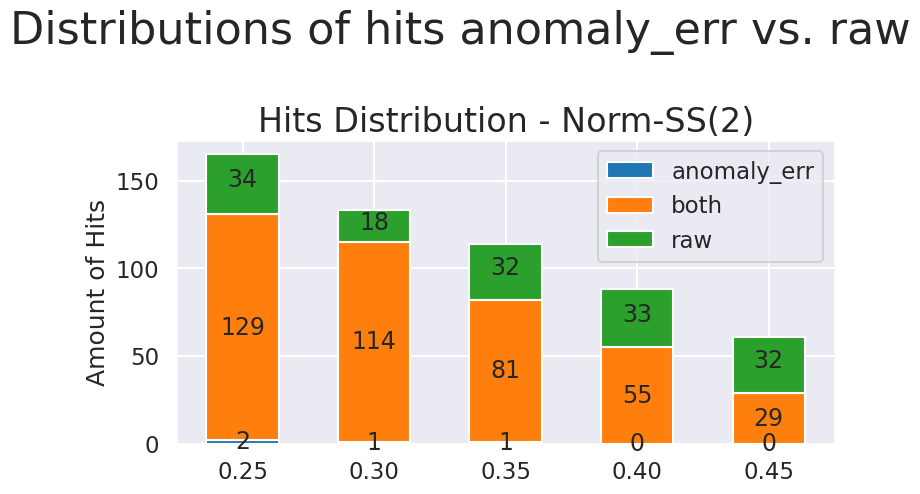

In [68]:
import matplotlib.pyplot as plt

for (mtd_a, mtd_b), cur_cs in cs.items():
    title = f'{mtd_a} vs. {mtd_b}'
# import matplotlib.pyplot as plt

for (mtd_a, mtd_b), cur_cs in cs.items():
    # try:
        plot_complementary(f'{mtd_a} vs. {mtd_b}', cur_cs, method_a=mtd_a,method_b=mtd_b)
    # plot_complementary('raw vs. 5to5', cur_cs, method_a=methods[mtd_a]['name'],method_b=methods[mtd_b]['name'], save_dir=exp_save_dir)
    # except:
        # print('Problem with', 'raw vs. 5to5')

## Plot Sensitivity

### Scatter plot

In [69]:
# https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

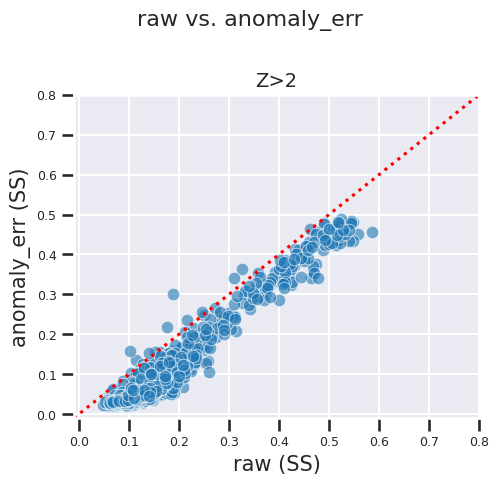

In [70]:

# ts = [2]
# ts=[2,4,6]
nrow = 1
ncol = len(ts)
metric= 'SS'

for name_b, name_a  in combs:
    
    chan=''
    d={'xlabel':f'{name_a} ({metric})', 'ylabel': f'{name_b} ({metric})'}
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5.3,nrow*5), subplot_kw=d, facecolor='white')
    fig.suptitle(f'{name_a} vs. {name_b}', fontsize = 16)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # for i, chan in enumerate(channels):
        # joined = ss_scores[mtd_a].join(ss_scores[mtd_b].filter(like=chan, axis=1), how='right', lsuffix=f'_{mtd_names[mtd_a]}', rsuffix=f'_{mtd_names[mtd_b]}')
    joined = methods[name_a]['ss'].join(methods[name_b]['ss'], how='right', lsuffix='_'+name_a, rsuffix='_'+name_b)

    # joined = joined[joined[f'Rep_Cnt_{name_a}']>=7]
    # joined = joined[joined[f'Rep_Cnt_{name_b}']<=8]
    for j, t in enumerate(t_thresholds):
        if len(ts)>1:
            ax = axs[j]
        else:
            ax = axs
        ax.set_title(f'Z>{t}')
        
        if len(chan)>0:
            _ = sns.scatterplot(data=joined, x=f'{chan}_{metric}_{t}_{name_a}', y=f'{chan}_{metric}_{t}_{name_b}', alpha=0.6, ax=ax)
        else:
            _ = sns.scatterplot(data=joined, x=f'{metric}_{t}_{name_a}', y=f'{metric}_{t}_{name_b}', alpha=0.6, ax=ax)
            # _ = sns.scatterplot(data=joined, x=f'SS_{t}_{name_a}', y=f'SS_{t}_{name_b}',hue=f'Rep_Cnt_{name_a}', alpha=0.6, ax=ax)


        add_identity(ax, color='r', ls=':')


        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                         bottom=True, top=False, left=True, right=False)
        ax.tick_params(axis='both', labelsize = 9)
        ax.yaxis.label.set_size(15)
        ax.xaxis.label.set_size(15)
        ax.title.set_size(14)
        # ax.legend(fontsize=10)
        # ax.set(xlim=(-0.01, 0.99), ylim=(-0.01, 0.99))
        if metric =='SS':
            if new_ss:
                ax.set(xlim=(-0.01, 0.2), ylim=(-0.01, 0.2))
            else:
                ax.set(xlim=(-0.01, 0.8), ylim=(-0.01, 0.8))
        else:
            ax.set(xlim=(-0.01, 0.1), ylim=(-0.01, 0.1))
    plt.tight_layout()
    plt.show()
        # _ = fig.legend(symbols, zscores.keys(), markerscale=1.2, loc='center right')#, fontsize='xx-large')

    _ = fig.savefig(f'{exp_save_dir}/ss-{name_a}-{name_b}.png', format='png')
    

### Violin plot 

In [71]:
results = []
for method in methods.keys():

    # res = (ss_scores[method].filter(like=f'{chan}_SS', axis=1).rename(lambda x: x.split('_')[-1], axis=1)).melt(var_name='Threshold', value_name='SS')
    res = (methods[method]['ss'].rename(lambda x: x.split('_')[-1], axis=1)).melt(var_name='Threshold', value_name='SS')
    # res['Channel'] = 'ALL'
    res['Method'] = method
    results.append(res)
res = pd.concat(results)

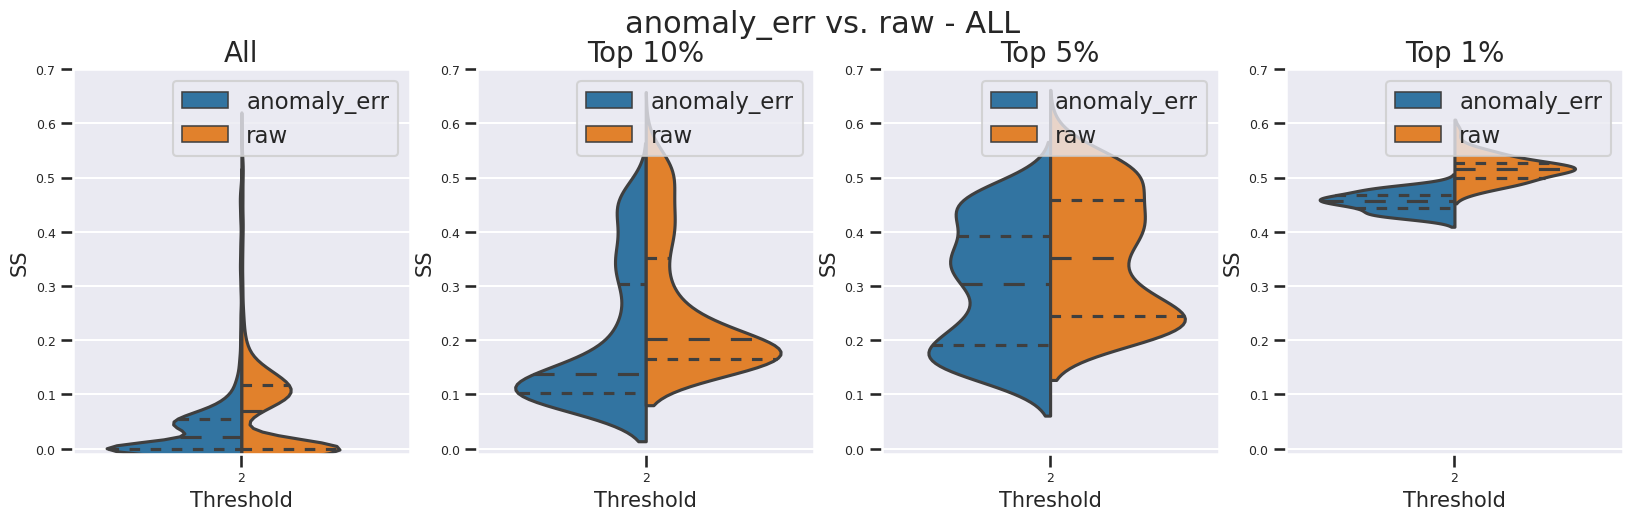

<Figure size 640x480 with 0 Axes>

In [72]:
nrow = 1
percentiles = [0,0.9,0.95,0.99]
ncol = len(percentiles)

d={'xlabel':"Threshold", 'ylabel':"SS"}
titles = ['All', 'Top 10%', 'Top 5%','Top 1%']

chan = 'ALL'


for mtd_a, mtd_b in combs:
    
    # name_a = methods[mtd_a]['name']
    # name_b = methods[mtd_b]['name']
    
    cur_data = res[res.Method.isin([mtd_a,mtd_b])]
    cur_data = cur_data[cur_data.Threshold.isin([str(i) for i in [2, 4, 6, 10, 14]])]
    # cur_data.Method = cur_data.Method.replace(methods.keys())
    # cur_data = cur_data[cur_data.Channel==chan]
    thresholds = cur_data.Threshold.unique()
    cur_methods = cur_data.Method.unique()

    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5,nrow*5), subplot_kw=d, facecolor='white')
    fig.suptitle(f'{mtd_a} vs. {mtd_b} - {chan}', fontsize=22, y=1)


    for i, p in enumerate(percentiles):

        data_outliers = pd.DataFrame()
        for t in thresholds:
            data_t = cur_data[cur_data['Threshold']==t]
            for j, m in enumerate(cur_methods):
                # print(m)
                data_m = data_t[data_t['Method']==m]
                # data_m.head()
                quantile = data_m['SS'].quantile(p)
                # print(quantile)
                data_m_outliers = data_m[data_m['SS']>quantile]  
                data_outliers = pd.concat([data_outliers, data_m_outliers])

        # _ = sns.boxplot(data=data_outliers, x='Threshold', y='SS',hue='Method', palette="Set2",ax=ax[i])
        _ = sns.violinplot(data=data_outliers, x='Threshold', y='SS', hue='Method', ax=ax[i], split=True, inner='quartile')
        del data_outliers

        ax[i].set_title(titles[i])
        ax[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                         bottom=True, top=False, left=True, right=False)
        ax[i].tick_params(axis='both', labelsize = 9)
        ax[i].yaxis.label.set_size(15)
        ax[i].xaxis.label.set_size(15)
        ax[i].title.set_size(20)
        ax[i].legend(loc='upper right')
        if new_ss:
            ax[i].set(ylim=(-0.01, 0.2))
        else:
            ax[i].set(ylim=(-0.01, 0.7))
        
    plt.show()
    plt.tight_layout()
    # _ = fig.savefig(f'{configs.general.fig_dir}/violin-{mtd_a}-{mtd_b}.png', format='png')
        
    

#     _ = fig.savefig(f'/sise/assafzar-group/g-and-n/tabular_models_results/plots/sensitivity/{mtd_names[mtd_a]} vs {mtd_names[mtd_b]} - ALL.png', format='png')
#     _ = fig.savefig(f'/sise/assafzar-group/g-and-n/tabular_models_results/plots/sensitivity/{mtd_names[mtd_a]} vs {mtd_names[mtd_b]} - ALL.eps', format='eps')


# Load results (PR and SS)
based on https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/1.Data-exploration/Profiles_level4/cell_painting/9.cellpainting-percent-replicating-subsampled-and-nonspherized.ipynb



In [73]:
import re
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
sns.set_context("talk")

In [74]:

df_null_p_vals= pd.read_csv(p_vals_path)
percantage_replicating_df = pd.read_csv(pr_path)
# df_null_p_vals.head()

# df_null_p_vals.corr()
# df_null_p_vals = p_vals3
# percantage_replicating_df = pr3

df_null_p_vals.rename( columns={'Unnamed: 0':'Metadata_broad_sample'}, inplace=True )
df_null_p_vals.set_index('Metadata_broad_sample',inplace=True)

In [75]:
# add fields of log p_vals 
for m in df_null_p_vals.keys():
    df_null_p_vals[m] = np.where(df_null_p_vals[m]<0.001,0.001,df_null_p_vals[m])
    df_null_p_vals[f'{m}_log'] = - np.log10(df_null_p_vals[m])
df_null_p_vals.isna().sum()


anomaly_err        0
raw                0
anomaly_err_log    0
raw_log            0
dtype: int64

In [76]:
percantage_replicating_df_non_melt = pd.merge(joined_ss,df_null_p_vals, left_on=methods[m]['ind_col'],right_index=True,suffixes=('','_p_val'))
percantage_replicating_df_non_melt.head()
percantage_replicating_df_non_melt.isna().sum()

Med_Corr_anomaly_err    0
SS_2_anomaly_err        0
MAS_2_anomaly_err       0
Med_Corr_raw            0
SS_2_raw                0
MAS_2_raw               0
anomaly_err             0
raw                     0
anomaly_err_log         0
raw_log                 0
dtype: int64

# Plot results
based on https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/1.Data-exploration/Profiles_level4/cell_painting/9.cellpainting-percent-replicating-subsampled-and-nonspherized.ipynb



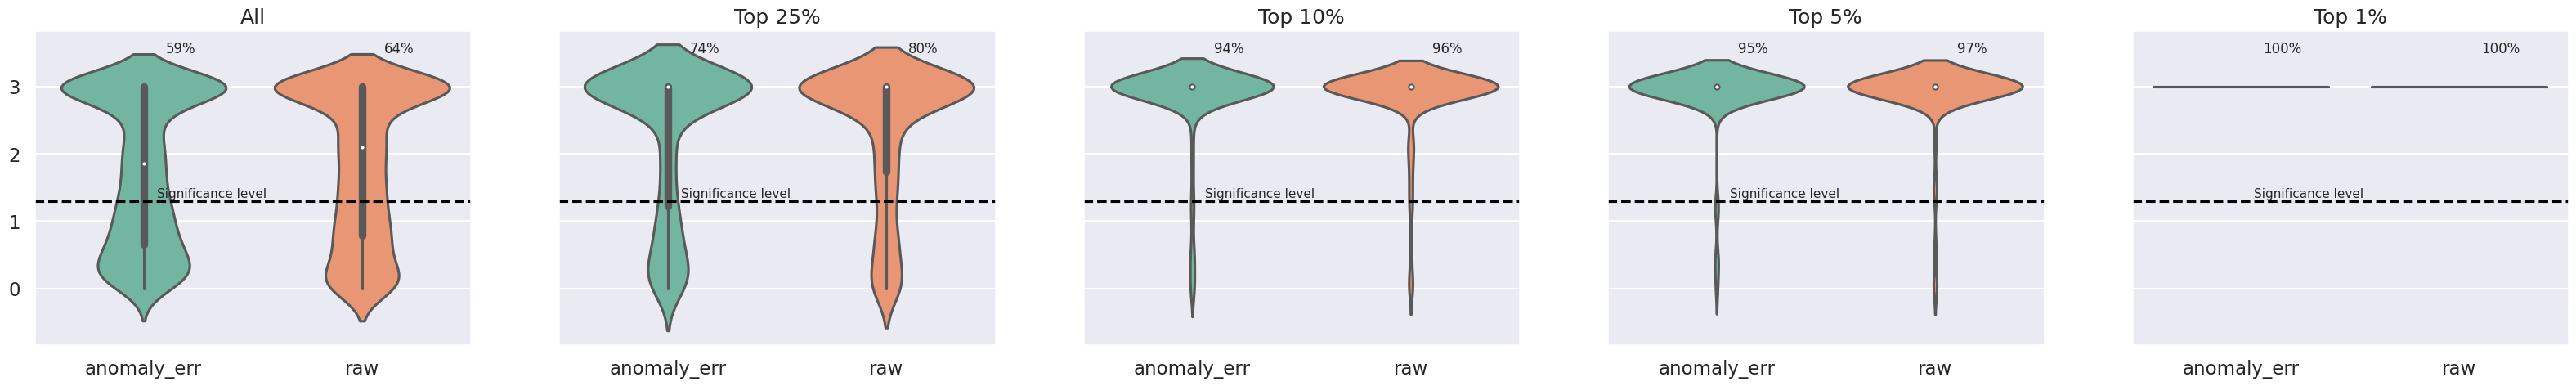

In [77]:

ts = [2,6]
t= 2

methods_labels:{
    'anomaly_err':'AnomalyCP',
    'raw':'CP',
}
# quantile_val = 0.95
quantile_vals = [0,0.75, 0.9,0.95,0.99]
titles = ['All', 'Top 25%', 'Top 10%', 'Top 5%','Top 1%']
new_methods =  methods.keys()
ncols = len(quantile_vals)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*8,5), facecolor='white',sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

num_total_cpds = len(percantage_replicating_df_non_melt)
num_cpds = [int((1-q)*num_total_cpds) for q in quantile_vals]
    # for ax, method in zip(dis_plt.axes.flat, methods):
            # ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],2)*100))+'%', fontsize=15)
for i, n in enumerate(num_cpds):
    

    ind={}
    violin = {}
    for m in new_methods:
        # quantile = percantage_replicating_df_non_melt[f'SS_{t}_{m}'].quantile(quantile_val)s
        sorted_by_method = percantage_replicating_df_non_melt.sort_values(by=f'SS_{t}_{m}', ascending=False)
        violin[methods_labels[m]] = sorted_by_method[f'{m}_log'][:n].values
        ind[methods_labels[m]] = sorted_by_method[f'{m}_log'][:n].index

    violin_df = pd.DataFrame(violin)
    _=sns.violinplot(data=violin_df, palette="Set2", ax=ax[i])
    log_val = -np.round(np.log10(0.05),5)
    ax[i].axhline(log_val, ls='--', c='black')
    # fig.legend(loc = 'lower right')
    ax[i].text(0.06,0.05+log_val, "Significance level",fontsize=11)
    ax[i].set_title(titles[i])
    for j, m in enumerate(new_methods):
            repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
            ax[i].text(0.1+j, 3.5,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
plt.show()
violin_df.isna().sum()
path= f'{exp_save_dir}/reproduce_by_ss{exp_suffix}.png'
fig.get_figure().savefig(path)
# violin_df.head()

/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 65.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 64.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 76.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 75.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/al

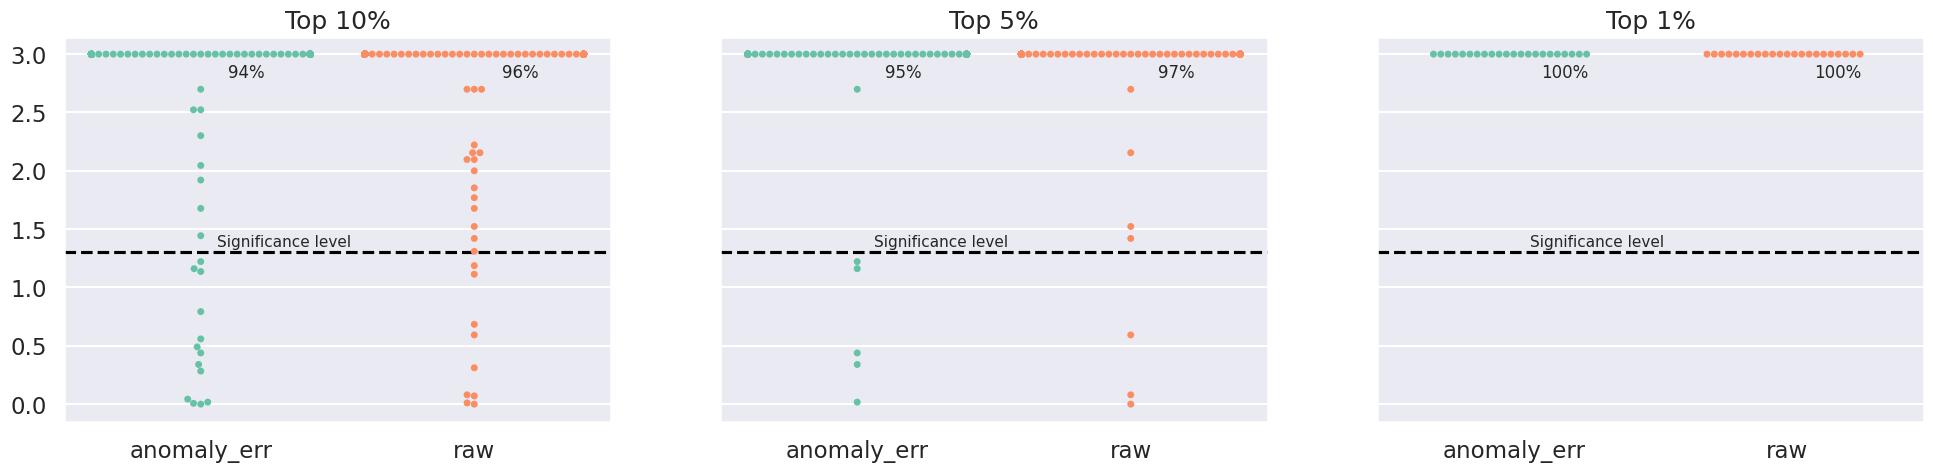

In [78]:
ts = [2,6]
t= 2
quantile_val = 0.95
quantile_vals = [0.9,0.95,0.99]
titles = ['Top 10%', 'Top 5%','Top 1%']
ncols = len(quantile_vals)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*8,5), facecolor='white',sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

num_total_cpds = len(percantage_replicating_df_non_melt)
num_cpds = [int((1-q)*num_total_cpds) for q in quantile_vals]
    # for ax, method in zip(dis_plt.axes.flat, methods):
            # ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],2)*100))+'%', fontsize=15)
for i, n in enumerate(num_cpds):
    

    ind={}
    violin = {}
    for m in new_methods:
        # quantile = percantage_replicating_df_non_melt[f'SS_{t}_{m}'].quantile(quantile_val)s
        sorted_by_method = percantage_replicating_df_non_melt.sort_values(by=f'SS_{t}_{m}', ascending=False)
        violin[method_labels[m]] = sorted_by_method[f'{m}_log'][:n].values
        ind[method_labels[m]] = sorted_by_method[f'{m}_log'][:n].index

    violin_df = pd.DataFrame(violin)
    # violin_df.replace('anomaly_err', 'AnomalyCP', inplace=True)
    # violin_df.replace('raw', 'CP', inplace=True)

    
    _=sns.swarmplot(data=violin_df, palette="Set2", ax=ax[i])
    
    log_val = -np.round(np.log10(0.05),5)
    ax[i].axhline(log_val, ls='--', c='black')
    # fig.legend(loc = 'lower right')
    ax[i].text(0.06,0.05+log_val, "Significance level",fontsize=11)
    for j, m in enumerate(methods):
            repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
            ax[i].text(0.1+j, 2.8,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
            ax[i].set_title(titles[i])
plt.show()
violin_df.isna().sum()
path= f'{exp_save_dir}/reproduce_by_ss_swarm{exp_suffix}.png'
fig.get_figure().savefig(path)
# violin_df.head()

## Venn diagrams for all sensitive treatmeants 

In [85]:
# Define the substrings you want to check for
df = percantage_replicating_df_non_melt.copy()
reps = ['anomaly_err', 'raw']

# Create a list of columns to keep (not melting)
final_df = pd.DataFrame()
for s in reps:
    columns_to_keep = [col for col in df.columns if s in col]
    col_df = df[columns_to_keep]

    for col in col_df.columns:
        new_col_name = col.replace(s, '')
        col_df.rename(columns={col:new_col_name}, inplace=True)
    col_df['method'] = s
    # Melt the DataFrame based on the selected columns
    # melted_df = pd.melt(df, id_vars=columns_to_keep, value_vars=columns_to_melt,
                        # var_name='Variable', value_name='Value')
    final_df = pd.concat([final_df, col_df])

final_df.head()
    


/tmp/ipykernel_29576/1076732830.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_df.rename(columns={col:new_col_name}, inplace=True)
/tmp/ipykernel_29576/1076732830.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_df['method'] = s
/tmp/ipykernel_29576/1076732830.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_df.rename(columns={col:new_col_name}, inplace=

,Med_Corr_,SS_2_,MAS_2_,,_log,method
Metadata_broad_sample,,,,,,
BRD-A00100033-001-04-8,0.000155,0.112944,0.000172,0.025,1.602060,anomaly_err
BRD-A00267231-001-01-1,0.000042,0.081007,0.000076,0.789,0.102923,anomaly_err
BRD-A00327403-103-01-9,0.000054,0.073181,0.000082,0.699,0.155523,anomaly_err
BRD-A00520476-001-03-3,0.000054,0.061971,0.000075,0.713,0.146910,anomaly_err
BRD-A00827783-001-04-8,0.000120,0.061125,0.000111,0.127,0.896196,anomaly_err


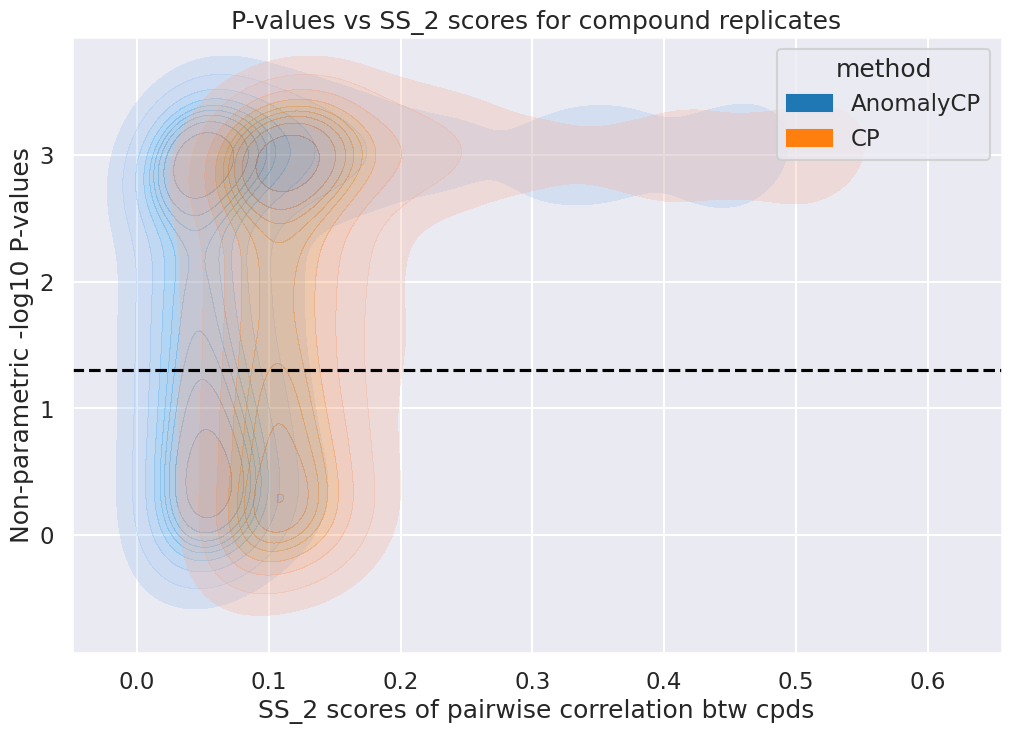

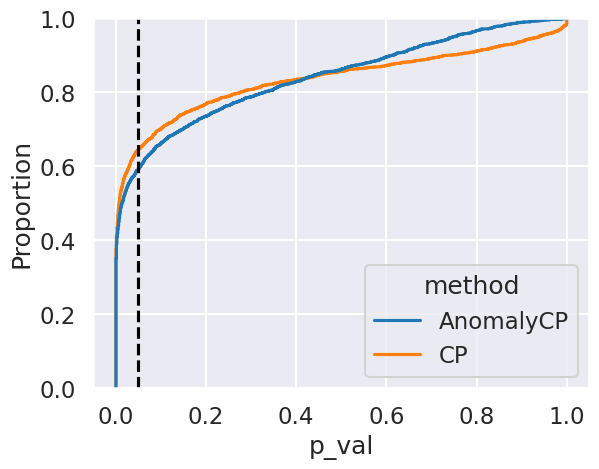

In [86]:
from utils.plotting import plot_p_vs_median
# row_indices = percantage_replicating_df['p_val']<0.0001
# percantage_replicating_df.loc[row_indices,'p_val']=0.0001
# percantage_replicating_df['log10_p_val'] = - np.log10(percantage_replicating_df['p_val'])
# x_col="fraction_score",y_col ="log10_p_val" 
final_df.rename(columns={'SS_2_':'SS_2'}, inplace=True)
final_df.rename(columns={'':'p_val'}, inplace=True)
final_df.rename(columns={'_log':'p_val_log'}, inplace=True)
final_df.replace('anomaly_err', 'AnomalyCP', inplace=True)
final_df.replace('raw', 'CP', inplace=True)


sns.ecdfplot(data=final_df, x="p_val", hue="method")
plt.axvline(0.05, ls='--', c='black')

path= f'{exp_save_dir}/p_val_ecdf_all{exp_suffix}.png'
fig.get_figure().savefig(path)

In [87]:
# ven diagram of all the compounds that are significant in all methods
# for each method plot the number of compounds that are significant in all methods
# for each method plot the number of compounds that are significant in all methods
# df_m_top_25.index

In [89]:
# subset_cpds

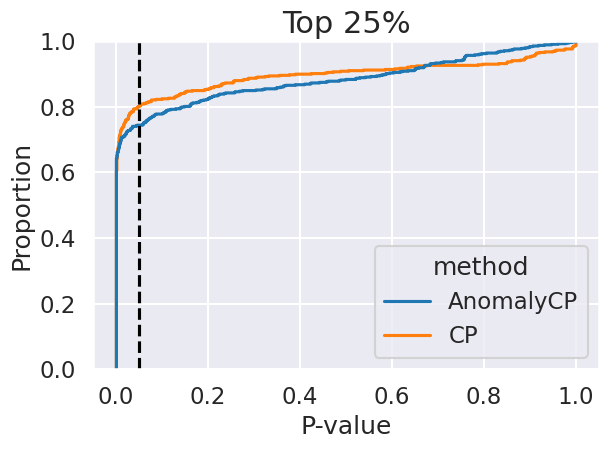

In [90]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

metric = "SS_2"
df_top_25 = pd.DataFrame()
inds = {}
subset_ratio = 0.25
# subset_cpds = int(len(final_df)*subset_ratio)
m_names = ['AnomalyCP', 'CP']
subset_cpds = int((len(final_df)*subset_ratio)/ len(m_names))
for m in m_names:
    df_m = final_df[final_df['method']==m]
    df_m_top_25 = df_m.sort_values(by=metric, ascending=False)[:subset_cpds]
    # quantile = df_m[metric].quantile(0.75)
    # df_m_top_25 = df_m[df_m[metric]>quantile]
    inds[m] = df_m_top_25.index

    # sorted_by_method = percantage_replicating_df_non_melt.sort_values(by=f'SS_{t}_{m}', ascending=False)
    # violin[m] = sorted_by_method[f'{m}_log'][:n].values
    # ind[m] = sorted_by_method[f'{m}_log'][:n].index


    df_top_25 = pd.concat([df_top_25, df_m_top_25])

# plot_p_vs_median(df_top_25,'cellpainting_figures', 'p_vs_ss_log.png',x_col="SS_2", y_col="p_val_log", plot = 'kde')
plt.rcParams.update({'font.size': 17})
sns.ecdfplot(data=df_top_25, x="p_val", hue="method")
# plt.legend(loc='lower right')
plt.title('Top 25%',fontsize=22)
plt.xlabel('P-value')
plt.axvline(0.05, ls='--', c='black')
plt.tight_layout()

path= f'{exp_save_dir}/p_val_ecdf_25{exp_suffix}.png'
fig.get_figure().savefig(path)


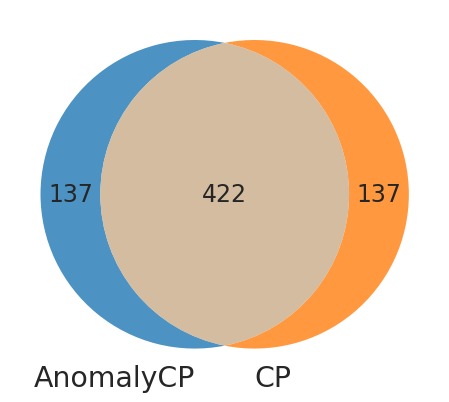

In [91]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
c = venn2([set(inds[m_names[0]]), set(inds[m_names[1]])], set_labels = (m_names[0],m_names[1]), set_colors=("tab:blue","tab:orange"),alpha=0.8)

path= f'{exp_save_dir}/p_val_venn_25{exp_suffix}.png'
fig.get_figure().savefig(path)

# c.get_label_by_id("100").set_x(1.55)
# c = venn2([set(inds[m_names[0]]), set(inds[m_names[1]])], set_labels = (m_names[0],m_names[1]),alpha=0.35)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


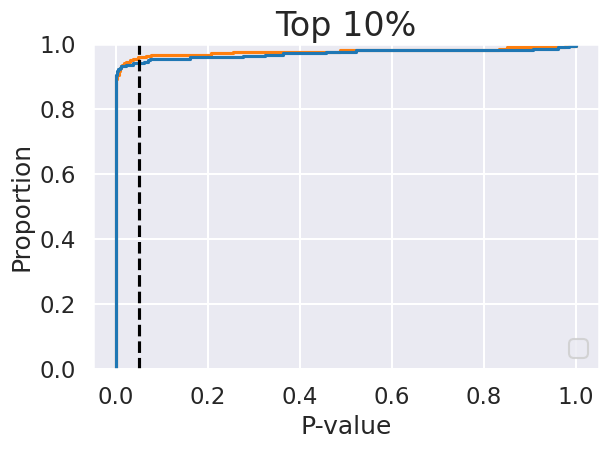

In [92]:
import seaborn as sns
df_top_25 = pd.DataFrame()
inds = {}
subset_ratio = 0.1
# subset_cpds = int(len(final_df)*subset_ratio)
m_names = ['AnomalyCP', 'CP']
subset_cpds = int((len(final_df)*subset_ratio)/ len(m_names))
for m in m_names:
    df_m = final_df[final_df['method']==m]
    df_m_top_25 = df_m.sort_values(by=metric, ascending=False)[:subset_cpds]
    # quantile = df_m[metric].quantile(0.75)
    # df_m_top_25 = df_m[df_m[metric]>quantile]
    inds[m] = df_m_top_25.index

    # sorted_by_method = percantage_replicating_df_non_melt.sort_values(by=f'SS_{t}_{m}', ascending=False)
    # violin[m] = sorted_by_method[f'{m}_log'][:n].values
    # ind[m] = sorted_by_method[f'{m}_log'][:n].index


    df_top_25 = pd.concat([df_top_25, df_m_top_25])

# plot_p_vs_median(df_top_25,'cellpainting_figures', 'p_vs_ss_log.png',x_col="SS_2", y_col="p_val_log", plot = 'kde')
plt.rcParams.update({'font.size': 17})

sns.ecdfplot(data=df_top_25, x="p_val", hue="method")
# sns.set(rc={'figure.figsize':(5,7)})
plt.legend(loc='lower right')
plt.title('Top 10%',fontsize=24)
plt.xlabel('P-value')
plt.axvline(0.05, ls='--', c='black')
plt.tight_layout()


path= f'{exp_save_dir}/p_val_ecdf_10{exp_suffix}.png'
fig.get_figure().savefig(path)



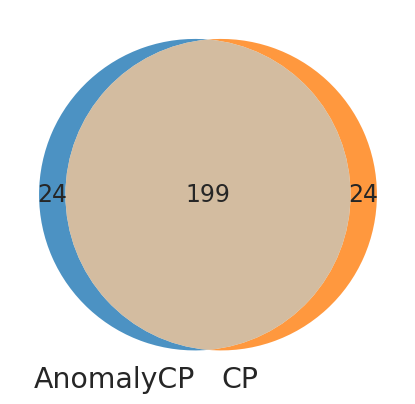

In [101]:
c = venn2([set(inds[m_names[0]]), set(inds[m_names[1]])], set_labels = (m_names[0],m_names[1]), set_colors=("tab:blue","tab:orange"),alpha=0.8)

path= f'{exp_save_dir}/p_val_venn_10{exp_suffix}.png'
fig.get_figure().savefig(path)


In [103]:
# plot_p_vs_median(final_df,'cellpainting_figures', 'p_vs_ss_log.png',x_col="SS_2", y_col="p_val_log", plot = 'kde')
len(inds[m_names[0]])


223

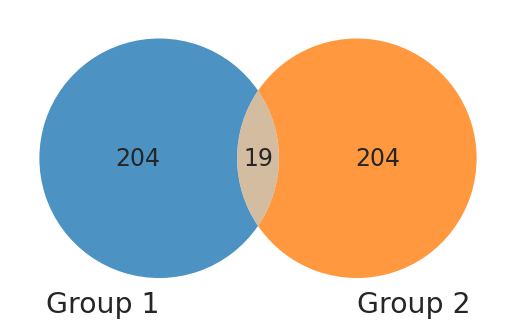

In [105]:
import numpy as np
from matplotlib_venn import venn2

# Generate random data
total_samples = len(percantage_replicating_df_non_melt)
group1_samples = np.random.choice(total_samples, size=int(total_samples*0.1), replace=False)
group2_samples = np.random.choice(total_samples, size=int(total_samples*0.1), replace=False)

# Create Venn diagram
venn2([set(group1_samples), set(group2_samples)], set_labels=('Group 1', 'Group 2'), set_colors=("tab:blue","tab:orange"),alpha=0.8)

path= f'{exp_save_dir}/p_val_venn_randomized.png'
fig.get_figure().savefig(path)



In [104]:
percantage_replicating_df_non_melt.head()

,Med_Corr_anomaly_err,SS_2_anomaly_err,MAS_2_anomaly_err,Med_Corr_raw,SS_2_raw,MAS_2_raw,anomaly_err,raw,anomaly_err_log,raw_log
Metadata_broad_sample,,,,,,,,,,
BRD-A00100033-001-04-8,0.000155,0.112944,0.000172,0.000116,0.222504,0.000209,0.025,0.207,1.602060,0.684030
BRD-A00267231-001-01-1,0.000042,0.081007,0.000076,0.000199,0.197335,0.000258,0.789,0.038,0.102923,1.420216
BRD-A00327403-103-01-9,0.000054,0.073181,0.000082,0.000123,0.141286,0.000172,0.699,0.193,0.155523,0.714443
BRD-A00520476-001-03-3,0.000054,0.061971,0.000075,0.000048,0.159264,0.000114,0.713,0.617,0.146910,0.209715
BRD-A00827783-001-04-8,0.000120,0.061125,0.000111,0.000160,0.105541,0.000169,0.127,0.103,0.896196,0.987163
